In [5]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import json
import torch.nn as nn
from torchvision.models.resnet import resnet50
import torchvision.transforms as transforms

In [6]:
img = Image.open('./test.JPEG')
img = img.convert('RGB')

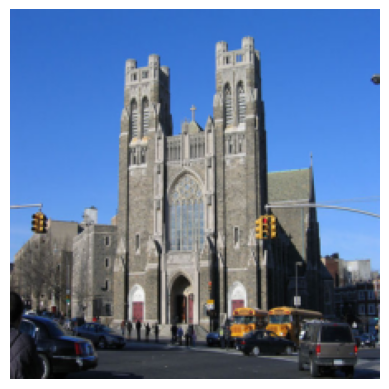

In [7]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])
img = transform(img)
img_hwc = img.permute(1, 2, 0)
plt.imshow(img_hwc)
plt.axis("off")
plt.show()
img = img.unsqueeze(dim=0)

In [8]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)
net = resnet50(num_classes=1000, pretrained=True)
model = nn.Sequential(Normalize(mean=imagenet_mean, std=imagenet_std), net)
model.eval()

c:\Users\xiaoxiangyey\.conda\envs\trustl\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\xiaoxiangyey\.conda\envs\trustl\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Normalize()
  (1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequen

In [9]:
model.eval()
prob = model(img)
label = torch.argmax(prob.squeeze())
target_class = json.load(open("imagenet_class_index.json"))[str(label.item())]
print("Natural Image:", target_class[1])

Natural Image: church


# Q1: PGD attack
According to the PPT or the original paper, implement the Projected Gradient Desent (PGD) attack.
https://arxiv.org/abs/1706.06083

In [10]:
def clamp(X, lower_limit, upper_limit):
    return torch.max(torch.min(X, upper_limit), lower_limit)

def attack_pgd(model, X, y, epsilon=8/255, alpha=2/255, attack_iters=10, restarts=1, lower_limit=torch.tensor([0]), upper_limit=torch.tensor([1])):
    """
    model: Model to attack.
    X: Input image
    y: Class of input image
    epsilon: Budget of PGD attack
    alpha: Step size for PGD attack
    attack_iters: Iterations for PGD attack
    restarts: Restarts for PGD attack
    lower limits: Lower limits for Input Images
    upper limits: Upper limits for Input Images
    """
    ###################################
    # write the code here
    max_delta = torch.zeros_like(X)
    max_loss = float('-inf')
    
    for _ in range(restarts):
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = torch.clamp(delta.data, -epsilon, epsilon)
        
        for _ in range(attack_iters):
            output = model(X + delta)
            loss = nn.CrossEntropyLoss()(output, y)
            loss.backward()
            grad = delta.grad.detach()
            delta.data = torch.clamp(delta + alpha * torch.sign(grad), -epsilon, epsilon)
            delta.data = clamp(delta.data, lower_limit - X, upper_limit - X)
            delta.grad.zero_()
        
        output = model(X + delta)
        total_loss = nn.CrossEntropyLoss()(output, y)
        
        if total_loss > max_loss:
            max_delta = delta.detach()
            max_loss = total_loss
            
    ###################################
    return max_delta

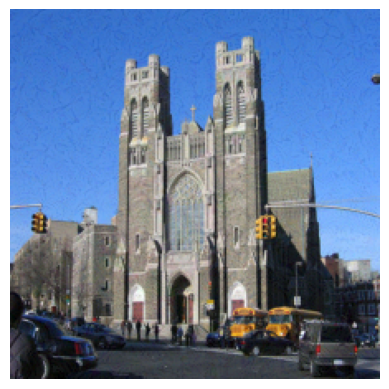

Adversarial Image: cab


In [11]:

delta = attack_pgd(model,img,label.unsqueeze(dim=0))
adv_img = img+delta
adv_img = adv_img.squeeze()
img_hwc = adv_img.permute(1, 2, 0)
plt.imshow(img_hwc)
plt.axis("off")
plt.show()
prob = model(adv_img)
label = torch.argmax(prob.squeeze())
target_class = json.load(open("imagenet_class_index.json"))[str(label.item())]
print("Adversarial Image:", target_class[1])

# Q2: C&W attack
According to the PPT shown in the class, implement the Carlini  Wagner (C&W) attack.
https://arxiv.org/pdf/1608.04644.pdf?source=post_page

In [12]:
def attack_cw(model, X, y, targeted=False, cw_kappa=0, cw_iters=10000, cw_c=1e-4, binary_search_steps = 9 , cw_lr= 0.01):
    """
    model: Model to attack
    X: Input image
    y: Class of input image
    targeted: Whether to apply targeted attack
    cw_kappa: kappa for C&W attack
    cw_iters: iteration for the C&W attack
    cw_c: constants for C&W attack
    binary_search_steps: steps for binary search
    cw_lr: learning rate for optimizer
    """
    def arctanh(imgs):
        scaling = torch.clamp(imgs, max=1, min=-1)
        x = 0.999999 * scaling
        return 0.5*torch.log((1+x)/(1-x))

    def scaler(x_atanh):
        return ((torch.tanh(x_atanh))+1) * 0.5

    def _f(adv_imgs, labels):
        ###################################
        # write the code here
        outputs = model(adv_imgs)
        correct_loss = torch.max(outputs * labels.float(), dim=1)[0]
        others_max, _ = torch.max(outputs * (1 - labels.float()), dim=1)
        loss = torch.clamp(others_max - correct_loss + cw_c, min=0)
        return torch.mean(loss)
        ###################################
        # return loss
        pass
    model.eval()
    X = X.detach().clone()
    x_arctanh = arctanh(X)
    for _ in tqdm.tqdm(range(binary_search_steps)):
        delta = torch.zeros_like(X)
        delta.detach_()
        delta.requires_grad = True
        optimizer = torch.optim.Adam([delta], lr=cw_lr)
        prev_loss = 1e6
        for step in range(cw_iters):
            optimizer.zero_grad()
            adv_examples = scaler(x_arctanh + delta)
            ###################################
            # write the code here
            loss = _f(adv_examples, y)
            loss.backward()
            optimizer.step()
            ###################################
            if step % (cw_iters // 10) == 0:
                if loss > prev_loss:
                    break
                prev_loss = loss
        adv_imgs = scaler(x_arctanh + delta).detach()
    return adv_imgs

In [13]:
import tqdm

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


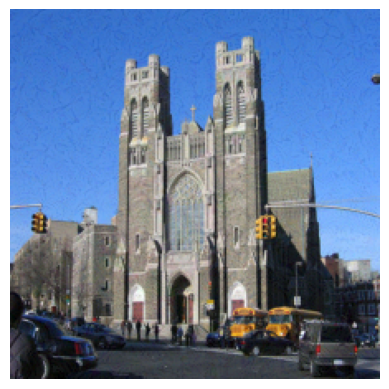

Adversarial Image: cab


In [14]:
adv_imgs = attack_cw(model,img,label.unsqueeze(dim=0),cw_iters=10)
adv_img = adv_img.squeeze()
img_hwc = adv_img.permute(1, 2, 0)
plt.imshow(img_hwc)
plt.axis("off")
plt.show()
prob = model(adv_img)
label = torch.argmax(prob.squeeze())
target_class = json.load(open("imagenet_class_index.json"))[str(label.item())]
print("Adversarial Image:", target_class[1])